# Estimating growth rates from absorbance data with Bootstrap methods

By Juan Manuel Pastor Ruiz and Paula Romero Jiménez

Date: September 2024

## Overview

This Jupyter Notebook applies bootstrapping methods to obtain growth rate data from experimental absorbance measurements.

It starts by reading and processing experimental data on absorbance and concentration. Then applies a bootstrap method to estimate growth rates and their errors, visualizes the results, and exports them to an Excel file. 

Key steps include:

- Data Preparation: Loading and organizing absorbance and concentration data from input files.
- Log Transformation: Calculating the logarithm of average absorbance values for different concentrations and time points.
- Bootstrap Analysis: Estimating growth rates and their errors through repeated resampling and linear fitting.
- Visualization: Generating plots to illustrate the fitted growth rates and their distributions.
- Export: Saving the processed data, growth rates, and associated errors to an Excel file for documentation and further analysis.



## Table of Contents
1. [Import Libraries](#import-libraries)
2. [Define Functions](#define-functions)
3. [Data Processing and Analysis](##data-processing-and-analysis)
4. [Plotting Results](#plotting-results)

## Import Libraries

In [1]:
# Import necessary libraries

# Data organization
import pandas as pd
import numpy as np

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm

## Define functions

`read_file_ntimes`: reads and organizes data from an Excel file containing the absorbance measurements.

Suggestion: The absorbance at time 0 is assumed to be the same for all drug concentrations, since it is measured before adding the treatment. It is recommended not to work with absorbance data that have more than 0.150 difference with their biological replicates. Those data that are deleted in Excel will be filled by the mean of the replicates in the program.

In [2]:
def read_file_ntimes (file, ntimes):
    """
    Funtion to read multiple sheets from an Excel file and organize them into a list of DataFrames.
    
    Parameters:
    file : str
        The file path or name of the Excel file containing the data. The file should contain multiple sheets,
        each representing consecutive time points (e.g., 0 hours, 24 hours, 48 hours).
        
    ntimes : int
        The number of sheets to read from the Excel file, representing different time points.
    
    Returns:
    list of pandas.DataFrame
        A list containing DataFrames for each time point (sheet) in the Excel file.
    """
    
    DF_list = list()
    sheets = range(ntimes) # Reads the specified number of sheets
    
    # Loop to process all sheets
    for sheet in sheets:
        df = pd.read_excel(file,decimal='.',sheet_name=sheet)
        cols = df.columns
        df.set_index(cols[0], inplace=True) # Set the first column (concentration) as the index
        
        # Fill NaN values with the mean of replicates
        df_filled = df.T.fillna(df.mean(axis=1)).T          
        
        # Add the processed DataFrame to the list
        DF_list.append(df_filled)
    
    return DF_list

`log_absorbance_data`: compute the logarithm of average absorbance data for each experiment at different time points.

In [3]:
def log_absorbance_data(dfs):
    """
    Compute the logarithm of absorbance data for each experiment and time point.
    
    Assumes columns for replicates are located consecutively for each experiment. 
    The total number of columns (excluding the concentration column) is:
        Number of replicates × Number of experiments
    
    Parameters:
    dfs : list of pandas.DataFrame
        A list of DataFrames, each representing data from a different time point. Each DataFrame should have:
        - 1st column: "Concentration".
        - Subsequent columns: Data for replicates of different experiments, with columns for replicates grouped together sequentially.
    
    Returns:
    tuple
        - Concentr: A NumPy array of concentration values (extracted from the index of the DataFrames).
        - logs_C_t: A 3D NumPy array with the logarithm of average absorbance values. The shape of the array is
          (number of concentrations, number of time points, number of experiments).
    """ 
    
    n_times = len(dfs) # Number of time points (DataFrames)
    shape = dfs[0].shape
    print('shape:', shape)
    n_exp = shape[-1] # Number of experiments (assuming 3 replicates per experiment)

    n_Conc = len(dfs[0].index) # Number of concentration levels
    Concentr = dfs[0].index.values # Array of concentration values
    
    print('n_times:', n_times, 'n_Conc:', n_Conc,'n_exp:', n_exp)
    
    # Initialize the array to hold logarithmic values
    logs_C_t = np.zeros((n_Conc, n_times, n_exp) )

    for i_C in range(n_Conc):
        for i_t in range(n_times):
            logs_C_t[i_C, i_t] = np.log(dfs[i_t].iloc[i_C,:].values)

    return Concentr, logs_C_t

`f_lin`: linear function for curve fitting.

In [4]:
def f_lin(x, a, b):
    """
    Computes a simple linear function.
    
    Parameters:
    x : float or np.ndarray
        The input value or array of values.
    a : float
        Slope of the linear function.
    b : float
        Intercept of the linear function.

    Returns:
    float or np.ndarray
        The computed value(s) of the linear function for the given input(s).
    """
    return  a*x + b

`calculate_growth_rate_bootstrap`:
1. Iterates by randomly sampling values with replacement from the original data (X, y) for each Bootstrap iteration.
2. Fits a line to the resampled data in each iteration.
3. Averages the line fits obtained from the different Bootstrap iterations to estimate the growth rate.
4. Calculates the standard error of the slopes and the 90% confidence interval for the growth rate.


In [5]:
def calculate_growth_rate_bootstrap(X, y, n_boot, name, save=False): 
    """
    Calculates the growth rate using the Bootstrap method by resampling the data, fitting a linear model,
    and averaging the results. The function also computes the 90% confidence interval for the growth rate.

    Parameters:
    X : array-like
        Input values representing the independent variable (e.g., time).
    y : array-like
        Dependent variable values (e.g., growth measurements).
    n_boot : int
        Number of Bootstrap iterations.
    name : str
        Name used for saving the plot (if `save=True`).
    save : bool, optional
        Whether to save the resulting plot as a file. Defaults to False.

    Returns:
    tuple
        - slope_mean: Mean of the growth rates obtained from Bootstrap iterations.
        - Interv_A: 90% confidence interval for the growth rate.
    """
    
    # Convert inputs to numpy arrays and flatten
    X0=np.array(X).ravel()
    y0=np.array(y).ravel()
    print('X:',X0)
    print('y:',y0)
    
    n_samples=len(X0)
    print('n_samples:', n_samples)
    
    # Initialize parameters for plotting and Bootstrap iterations
    n_points = n_boot
    n_param = 2  # Number of parameters for linear fit
    alpha = 0.05  # For 95% confidence interval
    
    # Create a figure with subplots for plotting
    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Arrays to store results from Bootstrap iterations    
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float) # Fitted values for each Bootstrap sample
    params_b = np.zeros((n_boot, n_param), dtype=float) # Parameters for each Bootstrap fit
    r2_b = np.zeros((n_boot), dtype = float)  # R^2 values for each fit
    
    npoints_plot = 1000
    X_plot = np.linspace(0,X0[-1],npoints_plot)
          
    nfit=0
    i_fit=0
   
    for i in range(n_boot):
        # Bootstrap: sample data with replacement
        i_index = np.random.choice(range(0, len(X0)), len(X0))
        X_boot = X0[i_index]    
        y_boot = y0[i_index]

        try:
            # Linear fit to the resampled data
            popt_b, pcov_b = curve_fit(f_lin, X_boot, y_boot)
            
            # Ensure parameters are within reasonable bounds
            if (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[0][0])<10):
                y_hat_i = f_lin(X_boot, *popt_b) # Predicted values for the resampled data
                y_hat_b[i_fit,:] = y_hat_i
                params_b[i_fit,:] = popt_b
                r2_b[i_fit] = r2_score(y_boot, y_hat_i)
    
                # Plot each fit line
                y_plot = f_lin(X_plot, *popt_b)
                ax1.plot(X_plot, y_plot, color='grey', alpha=0.1, zorder=1)
                plt.scatter(X_boot, y_boot, marker='o', color='orange', zorder=1)

                i_fit += 1
            
        except Exception as e:
            print(f'Error in curve_fit at iteration {i}: {e}')
    
    nfit = i_fit
    print('Number of successful fits:', nfit)
    
    # Calculate mean slope and its standard error
    params_mean = np.mean(params_b[:nfit,:], axis=0)
    slope_mean = params_mean[0]
    
    # Compute standard error of the slope
    sum_res2 = np.sum((params_b[:nfit,0] - slope_mean)**2) 
    SE_A = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2 / (nfit-1)) 
    t = stats.t.ppf(1-alpha, n_samples-2) # Student's t-value for 90% confidence interval   
    Interv_A = t * SE_A
    print('Mean slope:', slope_mean, '; 90% Confidence Interval:', Interv_A)
    
    # Plot results    
    ymin_plot, ymax_plot = plt.ylim()
    xmin_plot, xmax_plot = plt.xlim()
    print('ymin', ymin_plot)
    ax1.margins(0.01)
    
    # Plot mean fit line and add legend
    ax1.plot(X_plot, f_lin(X_plot, params_mean[0], params_mean[1]),'r', linewidth=4, 
             label="Slope={:.3f}; 90% CI ={:.3f}".format(slope_mean, Interv_A))
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('ln(N)')
    ax1.set_title(f'Growth Rate ({name}) - Bootstrap Results')
    ax1.grid(True)
    ax1.legend()

 
    n_bins=20
    
    # Histogram of R^2 values
    r2_plot = r2_b[:nfit].ravel()
    print('r^2_min:', r2_plot.min(), ';   resid_max:',r2_plot.max())
    ax2.hist(r2_plot, density=False, bins=n_bins, range=(r2_plot.min(), r2_plot.max()), histtype='barstacked', rwidth=0.8)   
    ax2.set_xlabel('r^2')
    
    # Histogram of growth rates
    #print('slopes:', params_b[:nfit,0])
    ax3.hist(params_b[:nfit,0], bins=n_bins, range=(params_b[:nfit,0].min(), params_b[:nfit,0].max()), histtype='barstacked', rwidth=0.8)
    ax3.set_xlim(( params_b[:nfit,0].min(), params_b[:nfit,0].max()))
    ax3.set_xlabel('Growth rate')
    
    # Fit and plot normal distribution for growth rates
    mu, std = norm.fit(params_b[:nfit,0])     
    xmin, xmax =(params_b[:nfit,0].min(), params_b[:nfit,0].max())
    print('xmin:', xmin, 'xmax:', xmax)
    x_norm = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x_norm, mu, std)
    
    bin_width = np.ptp(params_b[:nfit,0]) / n_bins
    print('mu:', mu, 'std:', std, 'bin_width:', bin_width)
    ax3.plot(x_norm, p_norm * nfit * bin_width, 'k', linewidth=4)    
    
    if save:
        filename = name + '_growth_rate.jpg'
        plt.savefig(filename)
        print('Figure saved as ', filename)

    
    plt.show()  
    
    return slope_mean, Interv_A

`export_growth_rates_to_excel`: exports concentration data, calculated growth rates, and their errors into an Excel file for further analysis.

In [6]:
def export_growth_rates_to_excel(concentr, growth_rates, errors, name):
    """
    Saves concentration, growth rates, and their errors to an Excel file.

    Parameters:
    concentr : array-like
        Array of concentration values.
    growth_rates : array-like
        Array of growth rates corresponding to each concentration.
    errors : array-like
        Array of errors for the growth rates.
    name : str
        Base name for the output Excel file.

    Returns:
    None
    """
    
    cols = ['Concentration', 'Growth Rate', 'Error']
    data = np.zeros([len(concentr), 3])

    for i_C in range(len(concentr)):
        print(f'i: {i_C}, Concentration: {concentr[i_C]}, Growth Rate: {growth_rates[i_C]}, Error: {errors[i_C]}\n\n')
        
        # Fill the data array
        data[i_C] = [concentr[i_C], growth_rates[i_C], errors[i_C]]
    
    # Create a DataFrame from the data
    df_r_C = pd.DataFrame(data, columns=cols)
    print('Data to be saved:', df_r_C)

    # Save the DataFrame to an Excel file
    filename = name + '_growth_rates.xlsx'
    df_r_C.to_excel(filename)
    print(f'Slopes and errors saved as {filename}')
 
    return

## Data Processing and Analysis

In [7]:
name = 'resultados mcf7'  # Base name for the Excel file
filename = name + '.xlsx'

# Define the number of time points to study
n_times = 4

# Read data from the file
dfs = read_file_ntimes(filename, n_times)

In [8]:
# Calculate the natural log of the mean values and errors


# Number of experiments and replicas
n_exp = len(dfs[0].columns)
n_rep = 1

# Get the concentration values and log-transformed growth measurements
concentr, logs_C_t = log_absorbance_data(dfs)

shape: (10, 12)
n_times: 4 n_Conc: 10 n_exp: 12


## Plotting Results

i_c: 0 Concentr: 0.0
resultados mcf7_C0p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.26744381 -0.31471074 -0.24931643 -0.32665393 -0.15121056 -0.17713503
 -0.21154442 -0.28768207 -0.33687232 -0.41198633 -0.4499396  -0.55686956
  0.09561316  0.05763978  0.08403473  0.07479821  0.24607852  0.13102826
  0.14149956  0.05826891  0.0181673   0.00929005 -0.03114673 -0.10536052
  0.3532357   0.34382608  0.30650383  0.2909268   0.39541477  0.34240697
  0.32738344  0.35370387  0.24659963  0.22766664  0.22607259  0.19666267]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.33851196814783824 ; 90% Confidence Interval: 0.048750604108659466
ymin -1.1785768106289696
r^2_min: 0.6608582418931337 ;   resid_max: 0.9468567171457488
xmin: 0.24225559144307074 xmax: 0.4317473625517303
mu: 

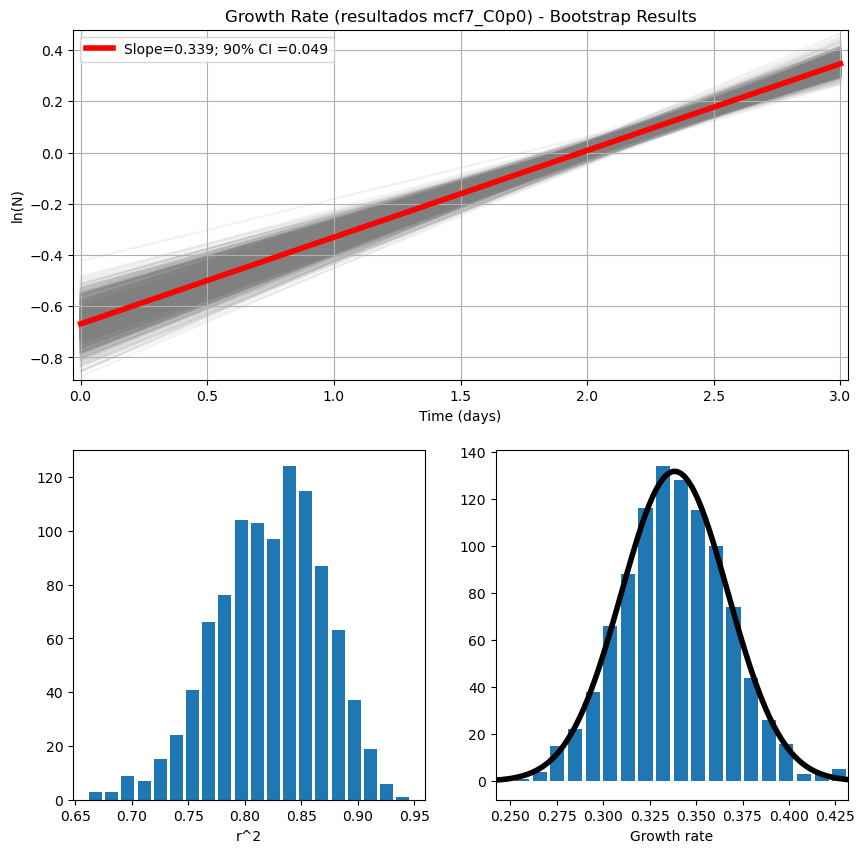

i_c: 1 Concentr: 1.5625
resultados mcf7_C1p56
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.28857136 -0.31745423 -0.31106443 -0.32850407 -0.14502577 -0.15237448
 -0.22731892 -0.26744381 -0.4499396  -0.44420594 -0.51138133 -0.51639667
 -0.00769621 -0.04395189 -0.04082199 -0.08338161  0.13278111  0.0500592
  0.0660998   0.05984    -0.04709161 -0.07652114 -0.12367536 -0.21030959
  0.23822919  0.23375373  0.22872793  0.21215001  0.32184192  0.27459683
  0.25593337  0.2646693   0.15272109  0.14669438  0.13860185  0.15643379]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.30741333150009087 ; 90% Confidence Interval: 0.04810964444518385
ymin -1.1748981682211608
r^2_min: 0.5680558242868246 ;   resid_max: 0.9090444750172628
xmin: 0.21443662493782212 xmax: 0.40706452245989666
m

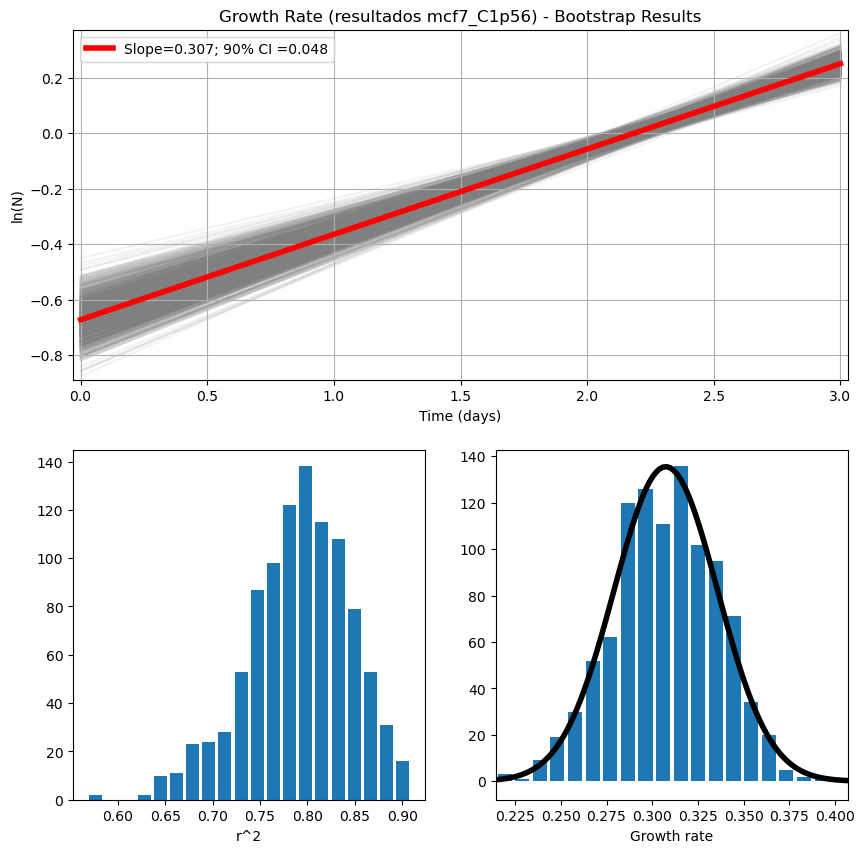

i_c: 2 Concentr: 3.125
resultados mcf7_C3p12
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.3905765  -0.44472582 -0.42210275 -0.44680807 -0.21154442 -0.17157946
 -0.28723773 -0.26179776 -0.47481519 -0.52143728 -0.57447565 -0.69248074
 -0.14734059 -0.16881321 -0.15043537 -0.16999781  0.08709471 -0.03424644
 -0.04082199 -0.04569496 -0.13849608 -0.16369609 -0.17713503 -0.29124396
  0.13219717  0.09166719  0.09105873  0.04624725  0.22474227  0.16607925
  0.16268558  0.16013275  0.09682418  0.06046775  0.06046775 -0.00133422]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.27331024733464937 ; 90% Confidence Interval: 0.04706951809103952
ymin -1.1700431856501319
r^2_min: 0.5046149180788099 ;   resid_max: 0.9263322544416841
xmin: 0.16410921241177157 xmax: 0.3490578388506077
mu

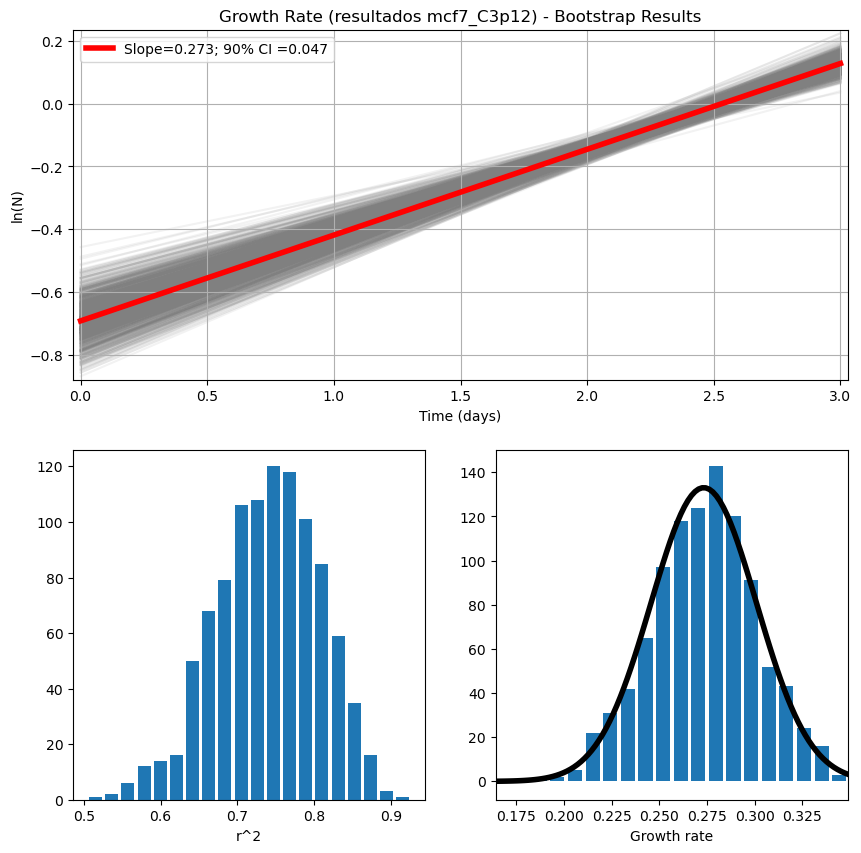

i_c: 3 Concentr: 6.25
resultados mcf7_C6p25
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.58339632 -0.56328919 -0.58459177 -0.60452599 -0.23067182 -0.25231493
 -0.25963466 -0.29079803 -0.4462871  -0.50252682 -0.58938795 -0.57684672
 -0.26353161 -0.27883246 -0.28015492 -0.28324748 -0.01477529 -0.08773891
 -0.06436076 -0.07724108 -0.17514735 -0.18472444 -0.26223094 -0.25231493
 -0.01139804 -0.0280566  -0.02977216 -0.02771384  0.13015068  0.08587184
  0.07942713  0.07170031 -0.02634398 -0.01680712 -0.03978087 -0.02565975]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.24319368525660873 ; 90% Confidence Interval: 0.050020814640409125
ymin -1.1653136062394889
r^2_min: 0.4305730262000257 ;   resid_max: 0.9004524985548796
xmin: 0.15761030105446394 xmax: 0.33318678684321695
m

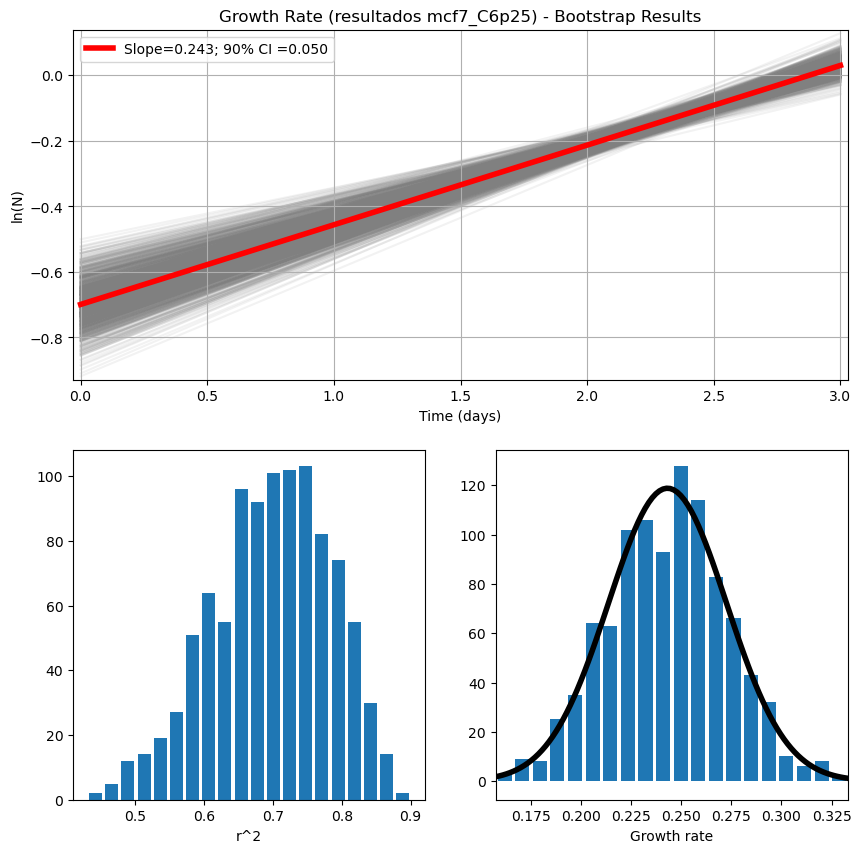

i_c: 4 Concentr: 12.5
resultados mcf7_C12p5
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.52481187 -0.60026419 -0.63048542 -0.57803437 -0.23910357 -0.25661416
 -0.26831527 -0.35050355 -0.54185773 -0.58519004 -0.60574699 -0.68849137
 -0.33640557 -0.41198633 -0.37736368 -0.3807725  -0.05094248 -0.10832788
 -0.11466291 -0.1492737  -0.20293251 -0.30788478 -0.28990677 -0.52876332
 -0.10388013 -0.16684199 -0.21236848 -0.20007828  0.07386985  0.02826347
  0.04242072 -0.00668899 -0.09138456 -0.11354204 -0.14425536 -0.15938659]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.20661895591885032 ; 90% Confidence Interval: 0.05023520110382836
ymin -1.1624995644445593
r^2_min: 0.1699005008502551 ;   resid_max: 0.8387211911072274
xmin: 0.11222937736863436 xmax: 0.30823511638049117
mu

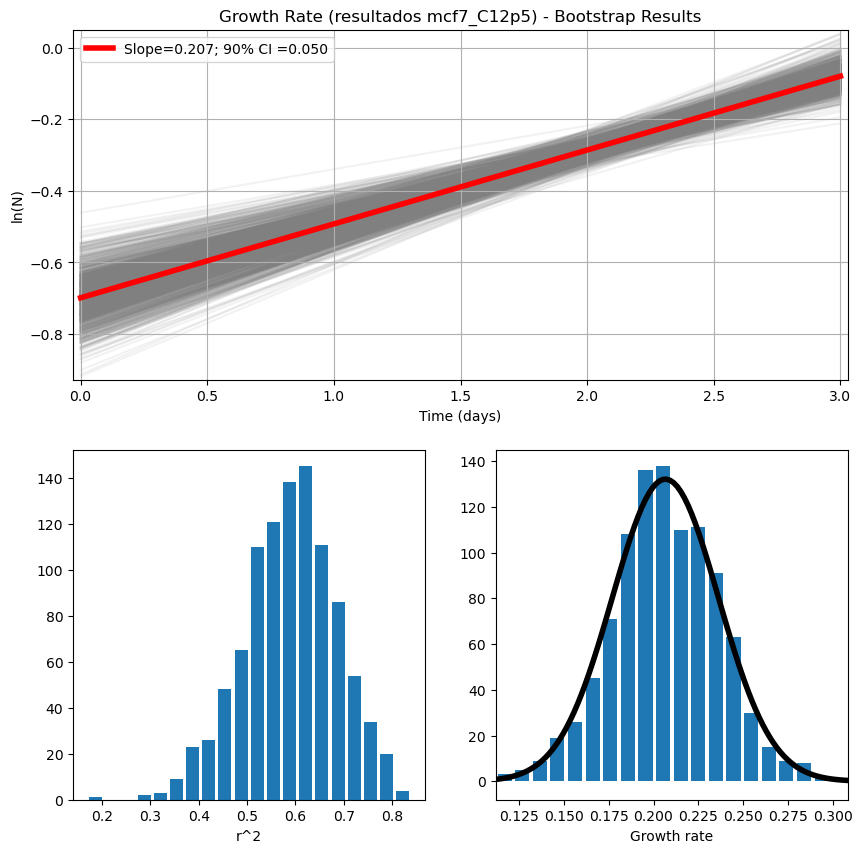

i_c: 5 Concentr: 25.0
resultados mcf7_C25p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.72086102 -0.70454523 -0.73050297 -0.74444047 -0.30426323 -0.35572302
 -0.37736368 -0.48126682 -0.60330648 -0.65520934 -0.75360515 -0.74584497
 -0.63299326 -0.64944933 -0.63424954 -0.65713674 -0.20661425 -0.30924625
 -0.28103753 -0.38959176 -0.42566782 -0.43129587 -0.48721761 -0.62299942
 -0.31516747 -0.34955748 -0.38959176 -0.34814004 -0.06649599 -0.1381133
 -0.12745466 -0.16016875 -0.3165389  -0.30245736 -0.34484049 -0.35762778]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.14187228947526268 ; 90% Confidence Interval: 0.05252621350270367
ymin -1.1554812724518184
r^2_min: 0.04557324452761258 ;   resid_max: 0.7884954674159352
xmin: 0.0368651686797139 xmax: 0.23776805416715455
mu:

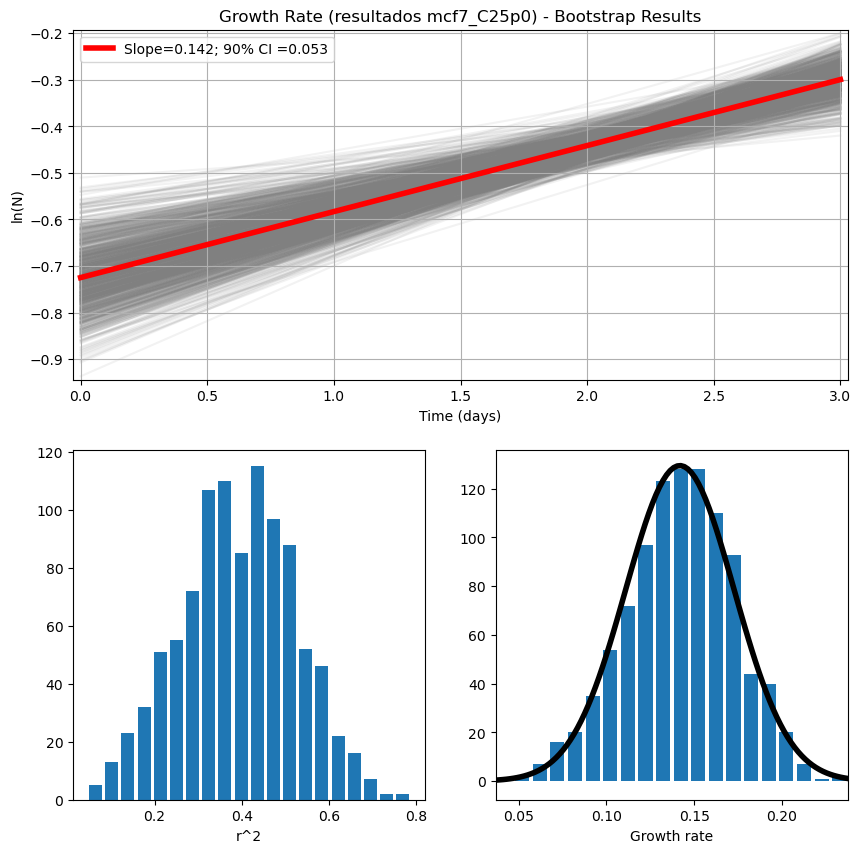

i_c: 6 Concentr: 50.0
resultados mcf7_C50p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.71812317 -0.77291215 -0.74936486 -0.80668922 -0.41855035 -0.38909975
 -0.42413837 -0.58339632 -0.66618073 -0.79259926 -0.81043034 -0.86433099
 -0.77580441 -0.71471136 -0.78088609 -0.80147506 -0.43335031 -0.52481187
 -0.56387484 -0.64817381 -0.6746526  -0.6558514  -0.70185162 -0.77508056
 -0.60330648 -0.68319685 -0.67990195 -0.66682987 -0.34672461 -0.41905706
 -0.41248972 -0.4764242  -0.60208845 -0.6336212  -0.62299942 -0.66164851]
n_samples: 48
Number of successful fits: 1000
Mean slope: 0.03930483349186075 ; 90% Confidence Interval: 0.05023100348755084
ymin -1.152641161199012
r^2_min: 1.5762556226928126e-07 ;   resid_max: 0.5141441283775068
xmin: -0.07168906052800095 xmax: 0.1316653240869194

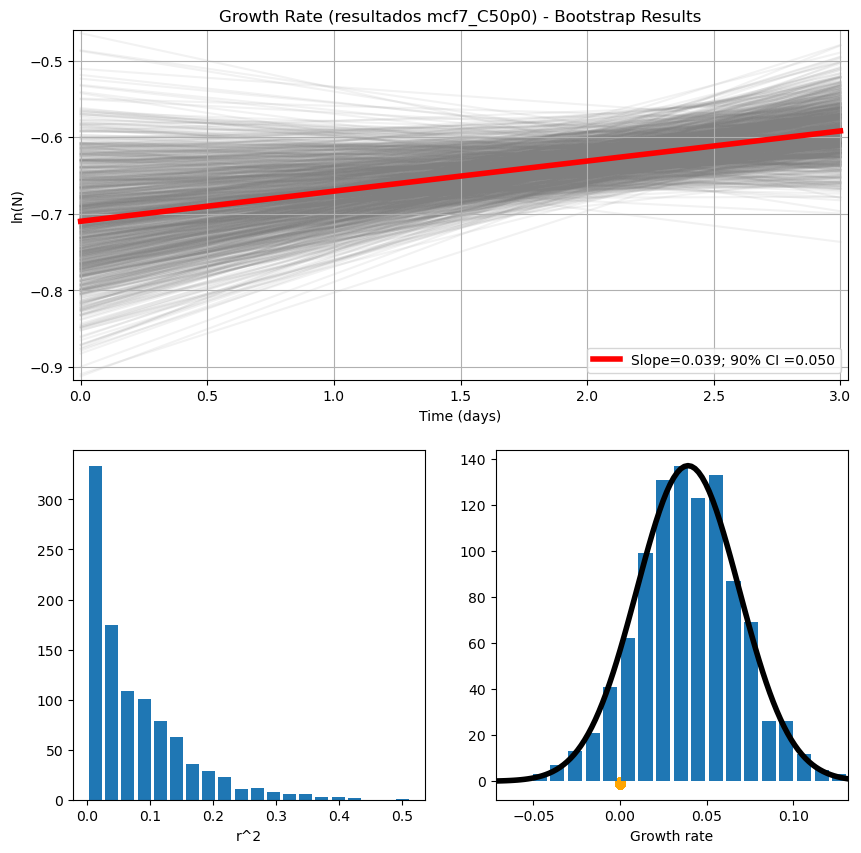

i_c: 7 Concentr: 100.0
resultados mcf7_C100p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -0.94160854 -1.01151758 -0.97728    -0.98439114 -0.63236571 -0.57684672
 -0.60452599 -0.94246361 -0.85019093 -1.16689113 -0.97816614 -1.0758728
 -1.19182467 -1.10866262 -1.1776555  -1.22644566 -0.83701755 -0.90881872
 -0.82629769 -0.98439114 -1.11372593 -1.20954385 -1.22872097 -1.42572843
 -1.24017585 -1.30563646 -1.23328719 -1.20064501 -0.88754132 -0.90551566
 -0.9204661  -0.9407542  -1.12598349 -1.26466687 -1.16903475 -1.32175584]
n_samples: 48
Number of successful fits: 1000
Mean slope: -0.1486001651357912 ; 90% Confidence Interval: 0.056253111954591505
ymin -1.4908499410663378
r^2_min: 0.07462403266687789 ;   resid_max: 0.6395623741085961
xmin: -0.2655610670266446 xmax: -0.0489145664389460

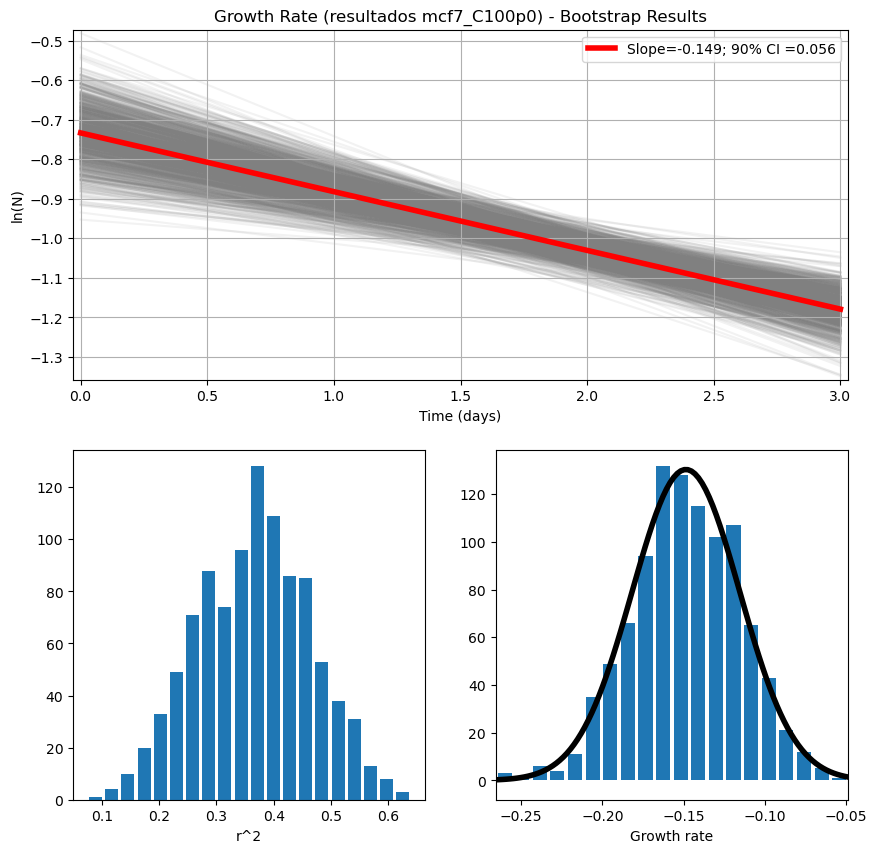

i_c: 8 Concentr: 150.0
resultados mcf7_C150p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -1.13943428 -1.21290144 -1.26940061 -1.25292965 -0.83624802 -0.81193072
 -1.00421161 -0.92718317 -1.1457039  -1.21627033 -1.21852259 -1.35221505
 -1.66248713 -1.69826913 -1.5847453  -1.73349056 -1.1776555  -1.25292965
 -1.2552661  -1.74487588 -1.52479044 -1.66248713 -1.7467861  -1.87080268
 -1.69281952 -1.93562984 -1.87731736 -1.8305003  -1.46389561 -1.49165488
 -1.43969514 -1.56064775 -1.69826913 -1.7641443  -1.87731736 -1.86003831]
n_samples: 48
Number of successful fits: 1000
Mean slope: -0.34717270084457547 ; 90% Confidence Interval: 0.057021279287238665
ymin -2.0262464208129205
r^2_min: 0.5745874350466517 ;   resid_max: 0.8490564674835054
xmin: -0.45725010518212406 xmax: -0.25226458951315

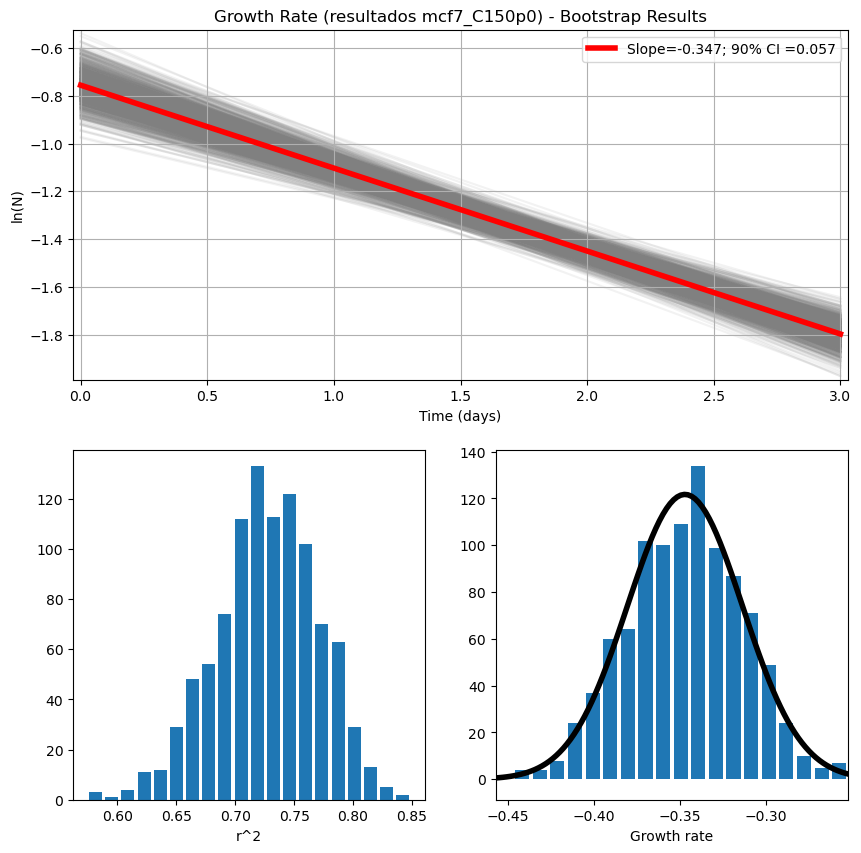

i_c: 9 Concentr: 200.0
resultados mcf7_C200p0
X: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3]
y: [-0.63929051 -0.67269117 -0.71607469 -0.78088609 -0.40047757 -0.12329822
 -0.26396555 -0.59420723 -1.08668372 -1.0069451  -1.06421086 -1.10362483
 -1.31925896 -1.49165488 -1.50058351 -1.43129173 -1.04507152 -1.03282455
 -1.06711362 -1.17982234 -1.20842715 -1.40513745 -1.41058705 -1.42711636
 -2.05572502 -2.19522657 -2.16282315 -2.14558134 -1.73349056 -1.72972408
 -1.64161681 -1.83885108 -1.90380897 -2.11196473 -2.15704279 -2.17155683
 -2.31263543 -2.3859667  -2.39323946 -2.33994088 -1.82428266 -2.06619631
 -2.09286456 -2.15416509 -2.21030982 -2.28933987 -2.23181602 -2.31939221]
n_samples: 48
Number of successful fits: 1000
Mean slope: -0.5245174295054089 ; 90% Confidence Interval: 0.05972736094951596
ymin -2.5067365235080605
r^2_min: 0.7523225769193944 ;   resid_max: 0.9290037360240675
xmin: -0.6678612127874028 xmax: -0.41493961146388303

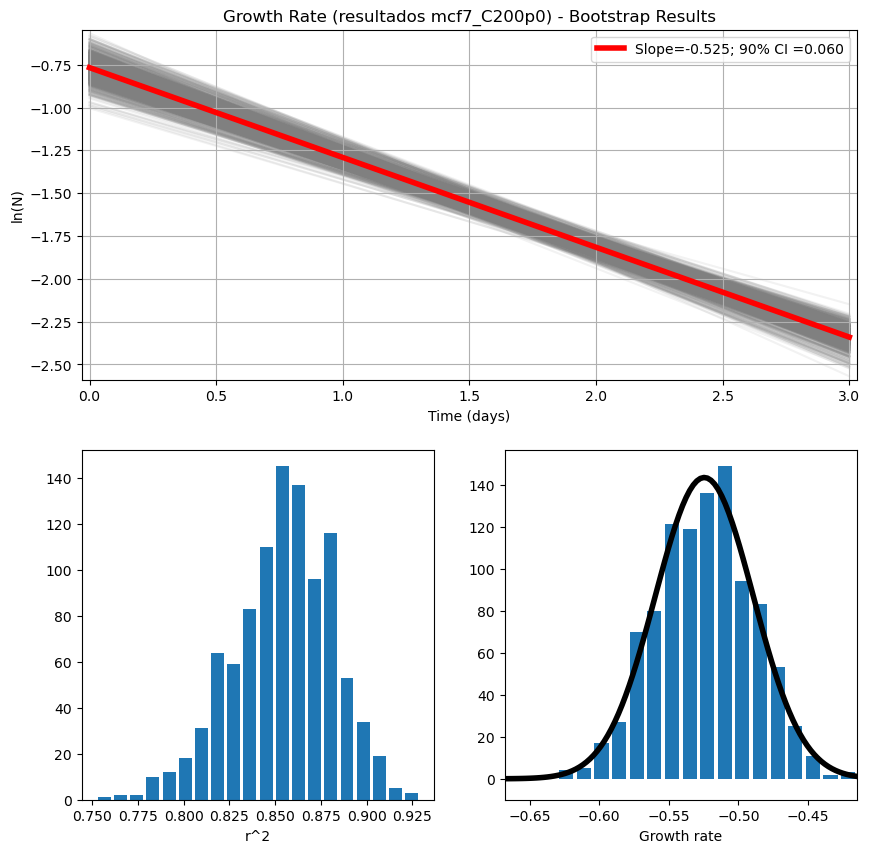

i: 0, Concentration: 0.0, Growth Rate: 0.33851196814783824, Error: 0.048750604108659466


i: 1, Concentration: 1.5625, Growth Rate: 0.30741333150009087, Error: 0.04810964444518385


i: 2, Concentration: 3.125, Growth Rate: 0.27331024733464937, Error: 0.04706951809103952


i: 3, Concentration: 6.25, Growth Rate: 0.24319368525660873, Error: 0.050020814640409125


i: 4, Concentration: 12.5, Growth Rate: 0.20661895591885032, Error: 0.05023520110382836


i: 5, Concentration: 25.0, Growth Rate: 0.14187228947526268, Error: 0.05252621350270367


i: 6, Concentration: 50.0, Growth Rate: 0.03930483349186075, Error: 0.05023100348755084


i: 7, Concentration: 100.0, Growth Rate: -0.1486001651357912, Error: 0.056253111954591505


i: 8, Concentration: 150.0, Growth Rate: -0.34717270084457547, Error: 0.057021279287238665


i: 9, Concentration: 200.0, Growth Rate: -0.5245174295054089, Error: 0.05972736094951596


Data to be saved:    Concentration  Growth Rate     Error
0         0.0000     0.338512  0

In [9]:
# Create a time array for plotting
time = [i for i in range(n_times) for _ in range(n_exp)]
X = np.array(time).reshape(-1, 1)  

n_boot = 1000  # Number of bootstrap iterations

slopes=[]
err_slopes=[]
for i_C in range(len(concentr)):
    print('i_c:', i_C,'Concentr:',concentr[i_C])
    y = logs_C_t[i_C]
    
    concent_str = str(np.round(concentr[i_C], 2))
    name_C = name + '_C'+ concent_str.replace('.','p')
    print(name_C)
    
    # Calculate slope and error using bootstrap
    slope_i, error_slope_i = calculate_growth_rate_bootstrap(X, y, n_boot,  name_C, False) 
    
    slopes.append(slope_i)
    err_slopes.append(error_slope_i)

# Save the results to an Excel file
export_growth_rates_to_excel(concentr, slopes, err_slopes, name)